### Урок3. Связь бизнес-показателей и DS-метрик

### Домашнее задание
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

### Определение ССЗ
ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [1]:
import numpy as np
import pandas as pd
import itertools

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


Bad key savefig.frameon in file /Users/vladimir/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/vladimir/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/vladimir/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  #

In [3]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

### Обучим LogisticRegression

Добавим классификатор и запустим кросс-валидацию

In [7]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [8]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую

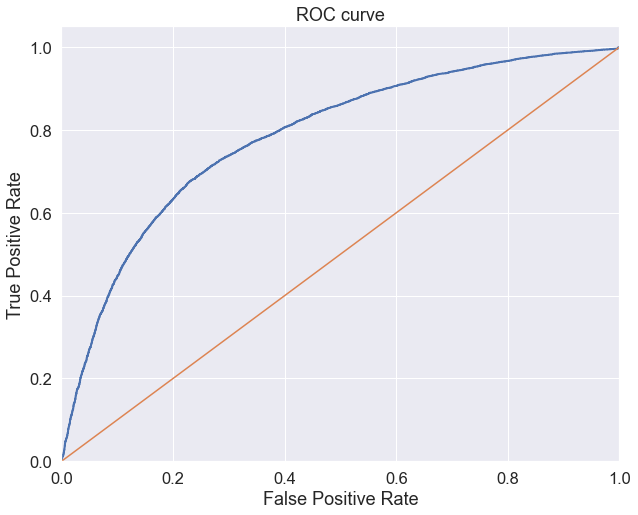

In [9]:
def roc_curve_plt(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

roc_curve_plt(y_test, y_score)

In [10]:
_f1_score = f1_score(y_test, [yhat for yhat in classifier.predict(X_test)])
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
_log_loss_score = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])

print("f1 score: {}".format(_f1_score))
print("roc auc score: {}".format(_roc_auc_score))
print("log loss score: {}".format(_log_loss_score))

f1 score: 0.7058466763706938
roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668


Посомтрим на матрицу ошибок

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


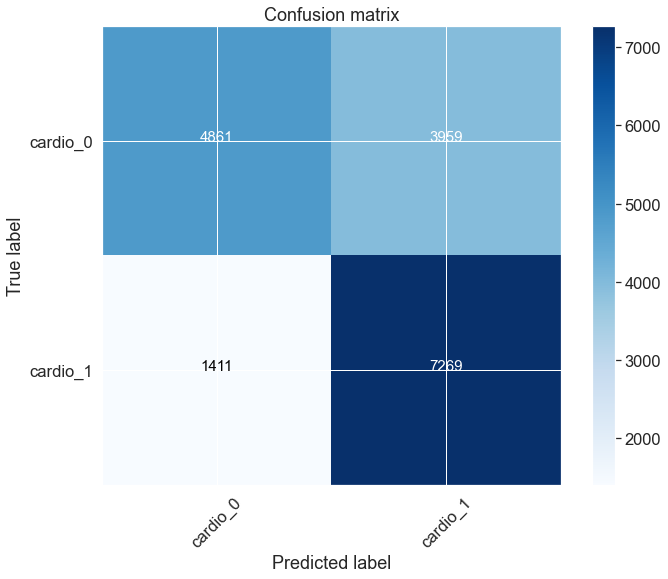

In [12]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [13]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

Добавим результаты в общую таблицу

In [14]:
resulting_models = pd.DataFrame(columns=['precision', 'recall', 'roc_auc', 'f1_score', 'log_loss', 'TPR', 'FPR', 'TNR'])

resulting_models.loc['LogisticRegression'] = [precision[ix], recall[ix], _roc_auc_score, _f1_score, _log_loss_score, TPR, FPR, TNR]

### Обучим XGBClassifier

In [15]:
classifier_xgb = Pipeline([
    ('features',feats),
    ('classifier_xgb', XGBClassifier(random_state = 42,
                                     learning_rate = 0.05,
                                     max_depth = 2,
                                     n_jobs=4)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_xgb, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_xgb.fit(X_train, y_train)
y_score = classifier_xgb.predict_proba(X_test)[:, 1]

CV score is 0.7976353272379371+-0.006542541378503091


In [16]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(ix)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

1946
Best Threshold=0.375417, F-Score=0.738, Precision=0.684, Recall=0.801


In [17]:
_f1_score = f1_score(y_test, [yhat for yhat in classifier_xgb.predict(X_test)])
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=classifier_xgb.predict_proba(X_test)[:,1])
_log_loss_score = log_loss(y_true=y_test, y_pred=classifier_xgb.predict_proba(X_test)[:,1])

print("f1 score: {}".format(_f1_score))
print("roc auc score: {}".format(_roc_auc_score))
print("log loss score: {}".format(_log_loss_score))

f1 score: 0.7101422726995177
roc auc score: 0.798071184310898
log loss score: 0.5469712533576148


Confusion matrix, without normalization
[[5608 3212]
 [1729 6951]]


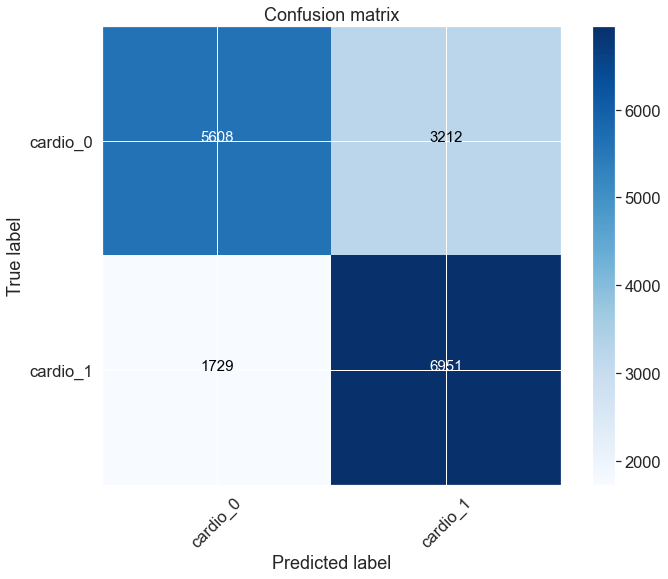

In [18]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [19]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8008064516129032, 0.364172335600907, 0.635827664399093)

Добавим результаты в общую таблицу

In [20]:
resulting_models.loc['XGBClassifier'] = [precision[ix], recall[ix], _roc_auc_score, _f1_score, _log_loss_score, TPR, FPR, TNR]
resulting_models

,precision,recall,roc_auc,f1_score,log_loss,TPR,FPR,TNR
LogisticRegression,0.647431,0.837558,0.784035,0.705847,0.577960,0.837442,0.448866,0.551134
XGBClassifier,0.683983,0.800922,0.798071,0.710142,0.546971,0.800806,0.364172,0.635828


### Обучим RandomForest

In [21]:
classifier_rf = Pipeline([
    ('features',feats),
    ('classifier_rf', RandomForestClassifier(random_state = 42,
                                     max_depth = 10,
                                     n_jobs=4)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_rf, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.8012814315210153+-0.006725085121681367


In [22]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(ix)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

7320
Best Threshold=0.400248, F-Score=0.740, Precision=0.697, Recall=0.790


In [23]:
_f1_score = f1_score(y_test, [yhat for yhat in classifier_rf.predict(X_test)])
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=classifier_rf.predict_proba(X_test)[:,1])
_log_loss_score = log_loss(y_true=y_test, y_pred=classifier_rf.predict_proba(X_test)[:,1])

print("f1 score: {}".format(_f1_score))
print("roc auc score: {}".format(_roc_auc_score))
print("log loss score: {}".format(_log_loss_score))

f1 score: 0.7171241670232928
roc auc score: 0.8015363399584103
log loss score: 0.5422887950983497


Confusion matrix, without normalization
[[5834 2986]
 [1827 6853]]


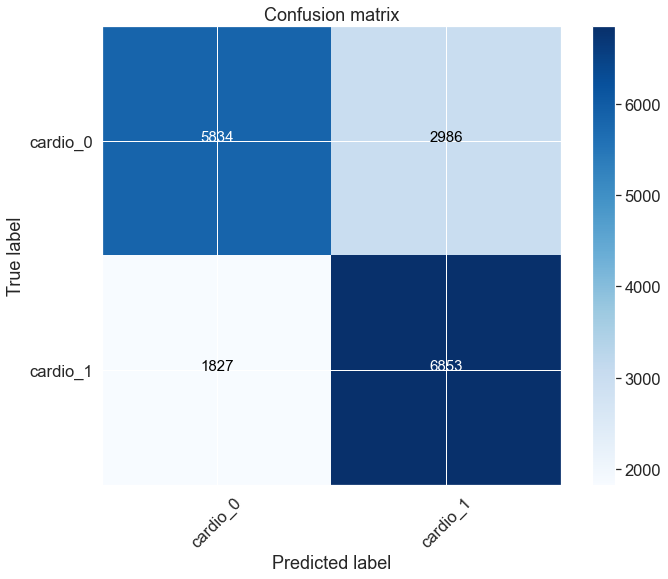

In [24]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [25]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7895161290322581, 0.3385487528344671, 0.6614512471655328)

Добавим результаты в общую таблицу

In [26]:
resulting_models.loc['RandomForestClassifier'] = [precision[ix], recall[ix], _roc_auc_score, _f1_score, _log_loss_score, TPR, FPR, TNR]

#### Выведем сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (строки - модели, столбцы - метрики)

In [27]:
resulting_models

,precision,recall,roc_auc,f1_score,log_loss,TPR,FPR,TNR
LogisticRegression,0.647431,0.837558,0.784035,0.705847,0.577960,0.837442,0.448866,0.551134
XGBClassifier,0.683983,0.800922,0.798071,0.710142,0.546971,0.800806,0.364172,0.635828
RandomForestClassifier,0.696545,0.789631,0.801536,0.717124,0.542289,0.789516,0.338549,0.661451


#### Сделаем выводы о том, какая модель справилась с задачей лучше других

В целом, модели дают очень схожие результаты, особенно если подбирать оптимальные thresholds.
В зависимости от задачи, можно улучшить показатели TPR (в ущерб precision и FPR, например) через подбор thresholds.

Пример RandomForestClassifier с коэффициентом в f_score (b=1.2):

In [28]:
b=1.2
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

_f1_score = f1_score(y_test, [yhat for yhat in classifier_rf.predict(X_test)])
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=classifier_rf.predict_proba(X_test)[:,1])
_log_loss_score = log_loss(y_true=y_test, y_pred=classifier_rf.predict_proba(X_test)[:,1])

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)

resulting_models.loc['RandomForestClassifier (b=1.2)'] = [precision[ix], recall[ix], _roc_auc_score, _f1_score, _log_loss_score, TPR, FPR, TNR]
resulting_models

,precision,recall,roc_auc,f1_score,log_loss,TPR,FPR,TNR
LogisticRegression,0.647431,0.837558,0.784035,0.705847,0.577960,0.837442,0.448866,0.551134
XGBClassifier,0.683983,0.800922,0.798071,0.710142,0.546971,0.800806,0.364172,0.635828
RandomForestClassifier,0.696545,0.789631,0.801536,0.717124,0.542289,0.789516,0.338549,0.661451
RandomForestClassifier (b=1.2),0.646431,0.858756,0.801536,0.717124,0.542289,0.858641,0.462245,0.537755


Таким образом, при прочих равных, RandomForestClassifier (b=1.2) выглядит наиболее удачной моделью в сравнении с остальными, если TPR для нас наиболее предпочтительнее FPR.

#### 5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

При дисбалансе классов лучше использовать precision_recall_curve.
Так как в roc_auc_curve горизонтальная ось использует FPR, то при несбалансированных классах большое количество негативных прогнозов приводит к чрезмерно оптимистической оценке.
В свою очередь precision_recall_curve, напротив, полностью сфокусирована на положительных примерах, поэтому более предпочтительна и позволяет легче сделать вывод о модели.

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic